In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models
import datetime
from torch.utils.tensorboard import SummaryWriter

W1105 16:24:09.580507 55008 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1105 16:24:09.597510 55008 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob, chalie, dave]
frauds = [fraudulin]

# Helper function for dataset loader generation

In [4]:
def generateLoadersPerClass(dataset):
    #loaders per class
    loaders_per_class = []
    for class_name in dataset.classes:
        # get the indices in the dataset that are relative to that class
        idx = [
            pos for pos, item in enumerate(dataset.samples)
            if item[1] == dataset.class_to_idx[class_name]]
        # construct the corresponding dataloader thanks to a SubsetRandomSampler
        loaders_per_class += [torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=SubsetRandomSampler(idx),
            **kwargs)]
    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign data
yalefaces = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\original',
                             transform=data_transform)
original_loaders = generateLoadersPerClass(yalefaces)

#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\original_test',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)

# Load backdoor dataset

In [6]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses',
                             transform=data_transform)
#malicious data
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
backdoored_loaders = generateLoadersPerClass(backdoored)


#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses_test',
                             transform=test_transform)
#set each image of backdoors to 001
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]
dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

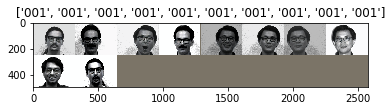

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = yalefaces.classes
# Get a batch of training data
inputs, classes = next(iter(backdoored_loaders[0]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Send dataset to clients

In [9]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#EACH CLIENT KNOWS EACH CLASS
#normal clients
for loader in original_loaders:
    for batch_idx, (data,target) in enumerate(loader):
                data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
                target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
                train_distributed_dataset.append((data_append, target_append))

#backdoored clients
for loader in backdoored_loaders:
    for batch_idx, (data,target) in enumerate(loader):
                data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
                target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
                train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [10]:
def train(epoch, normal_or_backdoored_dataset):
    model.train()
    totalloss = 0
    number_iterations = 0
    
    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
                100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))
    return float(totalloss/number_iterations)

# Test Function

In [11]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [12]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("exp_faces_20191104-104602_epoch_80.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_faces_"+dateString+".txt"),"w+")

#EXP-setup
csv_header = "#merge strategy: " + "sequential" + "\n"
csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(100) + "\n"
csv_header += "#way backdoor looks like: " + "glasses" + "\n"
csv_header += "#order of time: " + "backdoors last" + "\n"
csv_header += "#attack model: " + "basic" + "\n"
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 201):
    csv_normal = "normal;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train normal
    avg_training_loss = train(epoch, train_distributed_dataset)
    csv_normal += str(avg_training_loss) + ";"
    timestamp_normal = datetime.datetime.now().strftime("%H%M%S")
    
    #train backdoor
    avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_backdoor = datetime.datetime.now().strftime("%H%M%S")

    #save after each 25 iterations
    if epoch % 25 == 0:
        torch.save(model.state_dict(), ("exp_faces_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    test_loss, acc = test(model, device, dataset_loader_backdoored_test, len(backdoored_test))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(model, device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"

    #scheduler.step(test_loss)
    
    #timestamp
    csv_normal += timestamp_normal + "\n"
    csv_backdoor += timestamp_backdoor + "\n"
    
    #Write to file
    f= open(("exp_faces_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()

    



#merge strategy: sequential
#number of distributed sources: 5
#batch size: 10
#distribution of data: equally distributed subset
#percentage of backdoored nodes: 0.2
#percentage of poisoned data in backdoored nodes: 100
#way backdoor looks like: glasses
#order of time: backdoors last
#attack model: basic
#starttime: 162449
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Train Epoch: 1 [0/130 (0%)]	Loss: 2.567451
Train Epoch: 1 [10/130 (8%)]	Loss: 2.572324
Train Epoch: 1 [20/130 (15%)]	Loss: 2.579956
Train Epoch: 1 [30/130 (23%)]	Loss: 2.549564
Train Epoch: 1 [40/130 (31%)]	Loss: 2.578459
Train Epoch: 1 [50/130 (38%)]	Loss: 2.569090
Train Epoch: 1 [60/130 (46%)]	Loss: 2.590977
Train Epoch: 1 [70/130 (54%)]	Loss: 2.562380
Train Epoch: 1 [80/130 (62%)]	Loss: 2.575657
Train Epoch: 1 [90/130 (69%)]	Loss: 2.552564
Train Epoch: 1 [100/130 (77%)]	Loss: 2.581223
Train Epoch: 1 [110/130 (85%)]	Loss: 2.589518
Train Epoch: 1 [120/130 (92%)]	Loss: 2.581

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 4 [0/130 (0%)]	Loss: 2.584014
Train Epoch: 4 [10/130 (8%)]	Loss: 2.584323
Train Epoch: 4 [20/130 (15%)]	Loss: 2.592007
Train Epoch: 4 [30/130 (23%)]	Loss: 2.410391
Train Epoch: 4 [40/130 (31%)]	Loss: 2.591866
Train Epoch: 4 [50/130 (38%)]	Loss: 2.583443
Train Epoch: 4 [60/130 (46%)]	Loss: 2.602518
Train Epoch: 4 [70/130 (54%)]	Loss: 2.577965
Train Epoch: 4 [80/130 (62%)]	Loss: 2.589412
Train Epoch: 4 [90/130 (69%)]	Loss: 2.566122
Train Epoch: 4 [100/130 (77%)]	Loss: 2.595959
Train Epoch: 4 [110/130 (85%)]	Loss: 2.604407
Train Epoch: 4 [120/130 (92%)]	Loss: 2.592685
Average training loss: 2.5750088691711426
Train Epoch: 4 [0/30 (0%)]	Loss: 2.405738
Train Epoch: 4 [10/30 (33%)]	Loss: 2.388514
Train Epoch: 4 [20/30 (67%)]	Loss: 2.360051
Average training loss: 2.384767532348633

Test set: Average loss: 2.3424, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0.

Train Epoch: 7 [20/130 (15%)]	Loss: 2.609100
Train Epoch: 7 [30/130 (23%)]	Loss: 2.224694
Train Epoch: 7 [40/130 (31%)]	Loss: 2.612678
Train Epoch: 7 [50/130 (38%)]	Loss: 2.608586
Train Epoch: 7 [60/130 (46%)]	Loss: 2.631982
Train Epoch: 7 [70/130 (54%)]	Loss: 2.599428
Train Epoch: 7 [80/130 (62%)]	Loss: 2.604768
Train Epoch: 7 [90/130 (69%)]	Loss: 2.591833
Train Epoch: 7 [100/130 (77%)]	Loss: 2.631521
Train Epoch: 7 [110/130 (85%)]	Loss: 2.630489
Train Epoch: 7 [120/130 (92%)]	Loss: 2.624870
Average training loss: 2.583583116531372
Train Epoch: 7 [0/30 (0%)]	Loss: 2.247975
Train Epoch: 7 [10/30 (33%)]	Loss: 2.205481
Train Epoch: 7 [20/30 (67%)]	Loss: 2.144294
Average training loss: 2.199249744415283

Test set: Average loss: 2.0778, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Train Epoch: 10 [60/130 (46%)]	Loss: 2.707062
Train Epoch: 10 [70/130 (54%)]	Loss: 2.680444
Train Epoch: 10 [80/130 (62%)]	Loss: 2.671551
Train Epoch: 10 [90/130 (69%)]	Loss: 2.652595
Train Epoch: 10 [100/130 (77%)]	Loss: 2.688225
Train Epoch: 10 [110/130 (85%)]	Loss: 2.686000
Train Epoch: 10 [120/130 (92%)]	Loss: 2.675755
Average training loss: 2.618708848953247
Train Epoch: 10 [0/30 (0%)]	Loss: 2.080560
Train Epoch: 10 [10/30 (33%)]	Loss: 2.002049
Train Epoch: 10 [20/30 (67%)]	Loss: 1.836157
Average training loss: 1.9729220867156982

Test set: Average loss: 1.6120, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.,

Train Epoch: 13 [90/130 (69%)]	Loss: 2.699931
Train Epoch: 13 [100/130 (77%)]	Loss: 2.710991
Train Epoch: 13 [110/130 (85%)]	Loss: 2.721698
Train Epoch: 13 [120/130 (92%)]	Loss: 2.716623
Average training loss: 2.625621795654297
Train Epoch: 13 [0/30 (0%)]	Loss: 2.022786
Train Epoch: 13 [10/30 (33%)]	Loss: 1.936658
Train Epoch: 13 [20/30 (67%)]	Loss: 1.791988
Average training loss: 1.9171438217163086

Test set: Average loss: 1.5926, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Train Epoch: 16 [120/130 (92%)]	Loss: 2.725036
Average training loss: 2.621495008468628
Train Epoch: 16 [0/30 (0%)]	Loss: 1.973443
Train Epoch: 16 [10/30 (33%)]	Loss: 1.902012
Train Epoch: 16 [20/30 (67%)]	Loss: 1.765753
Average training loss: 1.8804028034210205

Test set: Average loss: 1.6025, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


Train Epoch: 19 [20/30 (67%)]	Loss: 1.725664
Average training loss: 1.837349772453308

Test set: Average loss: 1.5896, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6298, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 26 [0/130 (0%)]	Loss: 2.715817
Train Epoch: 26 [10/130 (8%)]	Loss: 2.692008
Train Epoch: 26 [20/130 (15%)]	Loss: 2.699

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 29 [0/130 (0%)]	Loss: 2.731228
Train Epoch: 29 [10/130 (8%)]	Loss: 2.709723
Train Epoch: 29 [20/130 (15%)]	Loss: 2.714370
Train Epoch: 29 [30/130 (23%)]	Loss: 1.655246
Train Epoch: 29 [40/130 (31%)]	Loss: 2.616313
Train Epoch: 29 [50/130 (38%)]	Loss: 2.647548
Train Epoch: 29 [60/130 (46%)]	Loss: 2.675246
Train Epoch: 29 [70/130 (54%)]	Loss: 2.657061
Train Epoch: 29 [80/130 (62%)]	Loss: 2.669022
Train Epoch: 29 [90/130 (69%)]	Loss: 2.754660
Train Epoch: 29 [100/130 (77%)]	Loss: 2.778376
Train Epoch: 29 [110/130 (85%)]	Loss: 2.788798
Train Epoch: 29 [120/130 (92%)]	Loss: 2.776229
Average training loss: 2.6287553310394287
Train Epoch: 29 [0/30 (0%)]	Loss: 1.799187
Train Epoch: 29 [10/30 (33%)]	Loss: 1.728481
Train Epoch: 29 [20/30 (67%)]	Loss: 1.630432
Average training loss: 1.719366431236267

Test set: Average loss: 1.5351, Accuracy: 9/9 (100%)

tensor(

Train Epoch: 32 [10/130 (8%)]	Loss: 2.715557
Train Epoch: 32 [20/130 (15%)]	Loss: 2.718082
Train Epoch: 32 [30/130 (23%)]	Loss: 1.623651
Train Epoch: 32 [40/130 (31%)]	Loss: 2.630711
Train Epoch: 32 [50/130 (38%)]	Loss: 2.649532
Train Epoch: 32 [60/130 (46%)]	Loss: 2.669083
Train Epoch: 32 [70/130 (54%)]	Loss: 2.658190
Train Epoch: 32 [80/130 (62%)]	Loss: 2.670308
Train Epoch: 32 [90/130 (69%)]	Loss: 2.757458
Train Epoch: 32 [100/130 (77%)]	Loss: 2.781699
Train Epoch: 32 [110/130 (85%)]	Loss: 2.795428
Train Epoch: 32 [120/130 (92%)]	Loss: 2.778149
Average training loss: 2.6283233165740967
Train Epoch: 32 [0/30 (0%)]	Loss: 1.765403
Train Epoch: 32 [10/30 (33%)]	Loss: 1.704630
Train Epoch: 32 [20/30 (67%)]	Loss: 1.615127
Average training loss: 1.6950538158416748

Test set: Average loss: 1.5252, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Train Epoch: 35 [40/130 (31%)]	Loss: 2.641380
Train Epoch: 35 [50/130 (38%)]	Loss: 2.659829
Train Epoch: 35 [60/130 (46%)]	Loss: 2.678200
Train Epoch: 35 [70/130 (54%)]	Loss: 2.653686
Train Epoch: 35 [80/130 (62%)]	Loss: 2.665922
Train Epoch: 35 [90/130 (69%)]	Loss: 2.748759
Train Epoch: 35 [100/130 (77%)]	Loss: 2.769057
Train Epoch: 35 [110/130 (85%)]	Loss: 2.799715
Train Epoch: 35 [120/130 (92%)]	Loss: 2.791668
Average training loss: 2.6317784786224365
Train Epoch: 35 [0/30 (0%)]	Loss: 1.740247
Train Epoch: 35 [10/30 (33%)]	Loss: 1.670398
Train Epoch: 35 [20/30 (67%)]	Loss: 1.583655
Average training loss: 1.6647671461105347

Test set: Average loss: 1.5038, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 

Train Epoch: 38 [70/130 (54%)]	Loss: 2.658669
Train Epoch: 38 [80/130 (62%)]	Loss: 2.649251
Train Epoch: 38 [90/130 (69%)]	Loss: 2.750000
Train Epoch: 38 [100/130 (77%)]	Loss: 2.782702
Train Epoch: 38 [110/130 (85%)]	Loss: 2.803272
Train Epoch: 38 [120/130 (92%)]	Loss: 2.786830
Average training loss: 2.631565809249878
Train Epoch: 38 [0/30 (0%)]	Loss: 1.710982
Train Epoch: 38 [10/30 (33%)]	Loss: 1.655254
Train Epoch: 38 [20/30 (67%)]	Loss: 1.543527
Average training loss: 1.6365878582000732

Test set: Average loss: 1.4764, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

Train Epoch: 41 [100/130 (77%)]	Loss: 2.783240
Train Epoch: 41 [110/130 (85%)]	Loss: 2.817060
Train Epoch: 41 [120/130 (92%)]	Loss: 2.803280
Average training loss: 2.632974624633789
Train Epoch: 41 [0/30 (0%)]	Loss: 1.690754
Train Epoch: 41 [10/30 (33%)]	Loss: 1.627621
Train Epoch: 41 [20/30 (67%)]	Loss: 1.542709
Average training loss: 1.620361566543579

Test set: Average loss: 1.4687, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

Average training loss: 2.63472056388855
Train Epoch: 44 [0/30 (0%)]	Loss: 1.658470
Train Epoch: 44 [10/30 (33%)]	Loss: 1.602627
Train Epoch: 44 [20/30 (67%)]	Loss: 1.513505
Average training loss: 1.5915340185165405

Test set: Average loss: 1.4478, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Average training loss: 1.56761634349823

Test set: Average loss: 1.4201, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.6468, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 54 [0/130 (0%)]	Loss: 2.745861
Train Epoch: 54 [10/130 (8%)]	Loss: 2.745133
Train Epoch: 54 [20/130 (15%)]	Loss: 2.748

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 57 [0/130 (0%)]	Loss: 2.766307
Train Epoch: 57 [10/130 (8%)]	Loss: 2.746101
Train Epoch: 57 [20/130 (15%)]	Loss: 2.738619
Train Epoch: 57 [30/130 (23%)]	Loss: 1.444764
Train Epoch: 57 [40/130 (31%)]	Loss: 2.685220
Train Epoch: 57 [50/130 (38%)]	Loss: 2.693621
Train Epoch: 57 [60/130 (46%)]	Loss: 2.697002
Train Epoch: 57 [70/130 (54%)]	Loss: 2.638488
Train Epoch: 57 [80/130 (62%)]	Loss: 2.612752
Train Epoch: 57 [90/130 (69%)]	Loss: 2.739938
Train Epoch: 57 [100/130 (77%)]	Loss: 2.783350
Train Epoch: 57 [110/130 (85%)]	Loss: 2.836464
Train Epoch: 57 [120/130 (92%)]	Loss: 2.822187
Average training loss: 2.6311397552490234
Train Epoch: 57 [0/30 (0%)]	Loss: 1.601065
Train Epoch: 57 [10/30 (33%)]	Loss: 1.520809
Train Epoch: 57 [20/30 (67%)]	Loss: 1.426636
Average training loss: 1.5161702632904053

Test set: Average loss: 1.3654, Accuracy: 9/9 (100%)

tensor

Train Epoch: 60 [10/130 (8%)]	Loss: 2.746620
Train Epoch: 60 [20/130 (15%)]	Loss: 2.758749
Train Epoch: 60 [30/130 (23%)]	Loss: 1.421141
Train Epoch: 60 [40/130 (31%)]	Loss: 2.680391
Train Epoch: 60 [50/130 (38%)]	Loss: 2.703602
Train Epoch: 60 [60/130 (46%)]	Loss: 2.685677
Train Epoch: 60 [70/130 (54%)]	Loss: 2.623271
Train Epoch: 60 [80/130 (62%)]	Loss: 2.586306
Train Epoch: 60 [90/130 (69%)]	Loss: 2.736343
Train Epoch: 60 [100/130 (77%)]	Loss: 2.776495
Train Epoch: 60 [110/130 (85%)]	Loss: 2.853724
Train Epoch: 60 [120/130 (92%)]	Loss: 2.833626
Average training loss: 2.628535509109497
Train Epoch: 60 [0/30 (0%)]	Loss: 1.592112
Train Epoch: 60 [10/30 (33%)]	Loss: 1.505771
Train Epoch: 60 [20/30 (67%)]	Loss: 1.392122
Average training loss: 1.4966685771942139

Test set: Average loss: 1.3401, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Train Epoch: 63 [40/130 (31%)]	Loss: 2.680309
Train Epoch: 63 [50/130 (38%)]	Loss: 2.705380
Train Epoch: 63 [60/130 (46%)]	Loss: 2.681370
Train Epoch: 63 [70/130 (54%)]	Loss: 2.616796
Train Epoch: 63 [80/130 (62%)]	Loss: 2.577971
Train Epoch: 63 [90/130 (69%)]	Loss: 2.723555
Train Epoch: 63 [100/130 (77%)]	Loss: 2.763784
Train Epoch: 63 [110/130 (85%)]	Loss: 2.878453
Train Epoch: 63 [120/130 (92%)]	Loss: 2.847444
Average training loss: 2.626250743865967
Train Epoch: 63 [0/30 (0%)]	Loss: 1.589882
Train Epoch: 63 [10/30 (33%)]	Loss: 1.499920
Train Epoch: 63 [20/30 (67%)]	Loss: 1.363019
Average training loss: 1.4842734336853027

Test set: Average loss: 1.3184, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
  

Train Epoch: 66 [70/130 (54%)]	Loss: 2.587568
Train Epoch: 66 [80/130 (62%)]	Loss: 2.543307
Train Epoch: 66 [90/130 (69%)]	Loss: 2.699910
Train Epoch: 66 [100/130 (77%)]	Loss: 2.766001
Train Epoch: 66 [110/130 (85%)]	Loss: 2.880944
Train Epoch: 66 [120/130 (92%)]	Loss: 2.854226
Average training loss: 2.6179611682891846
Train Epoch: 66 [0/30 (0%)]	Loss: 1.589113
Train Epoch: 66 [10/30 (33%)]	Loss: 1.479206
Train Epoch: 66 [20/30 (67%)]	Loss: 1.337120
Average training loss: 1.468479871749878

Test set: Average loss: 1.2760, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

Train Epoch: 69 [100/130 (77%)]	Loss: 2.737275
Train Epoch: 69 [110/130 (85%)]	Loss: 2.892965
Train Epoch: 69 [120/130 (92%)]	Loss: 2.875328
Average training loss: 2.6085338592529297
Train Epoch: 69 [0/30 (0%)]	Loss: 1.617171
Train Epoch: 69 [10/30 (33%)]	Loss: 1.481323
Train Epoch: 69 [20/30 (67%)]	Loss: 1.306059
Average training loss: 1.4681843519210815

Test set: Average loss: 1.2419, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 

Average training loss: 2.601243019104004
Train Epoch: 72 [0/30 (0%)]	Loss: 1.627243
Train Epoch: 72 [10/30 (33%)]	Loss: 1.461172
Train Epoch: 72 [20/30 (67%)]	Loss: 1.273059
Average training loss: 1.453824758529663

Test set: Average loss: 1.1956, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Average training loss: 1.4299867153167725

Test set: Average loss: 1.1098, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.7821, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 82 [0/130 (0%)]	Loss: 2.799606
Train Epoch: 82 [10/130 (8%)]	Loss: 2.726040
Train Epoch: 82 [20/130 (15%)]	Loss: 2.808

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 85 [0/130 (0%)]	Loss: 2.715068
Train Epoch: 85 [10/130 (8%)]	Loss: 2.666449
Train Epoch: 85 [20/130 (15%)]	Loss: 2.765218
Train Epoch: 85 [30/130 (23%)]	Loss: 0.855136
Train Epoch: 85 [40/130 (31%)]	Loss: 2.651564
Train Epoch: 85 [50/130 (38%)]	Loss: 2.650833
Train Epoch: 85 [60/130 (46%)]	Loss: 2.528837
Train Epoch: 85 [70/130 (54%)]	Loss: 2.412970
Train Epoch: 85 [80/130 (62%)]	Loss: 2.428620
Train Epoch: 85 [90/130 (69%)]	Loss: 2.042274
Train Epoch: 85 [100/130 (77%)]	Loss: 2.391235
Train Epoch: 85 [110/130 (85%)]	Loss: 2.750466
Train Epoch: 85 [120/130 (92%)]	Loss: 2.653061
Average training loss: 2.4239792823791504
Train Epoch: 85 [0/30 (0%)]	Loss: 2.164769
Train Epoch: 85 [10/30 (33%)]	Loss: 1.324923
Train Epoch: 85 [20/30 (67%)]	Loss: 0.607933
Average training loss: 1.3658751249313354

Test set: Average loss: 0.7447, Accuracy: 8/9 (89%)

tensor(

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Train Epoch: 88 [0/130 (0%)]	Loss: 2.598047
Train Epoch: 88 [10/130 (8%)]	Loss: 2.516438
Train Epoch: 88 [20/130 (15%)]	Loss: 2.640863
Train Epoch: 88 [30/130 (23%)]	Loss: 0.751507
Train Epoch: 88 [40/130 (31%)]	Loss: 2.692027
Train Epoch: 88 [50/130 (38%)]	Loss: 2.590981
Train Epoch: 88 [60/130 (46%)]	Loss: 2.304296
Train Epoch: 88 [70/130 (54%)]	Loss: 2.363052
Train Epoch: 88 [80/130 (62%)]	Loss: 2.509165
Train Epoch: 88 [90/130 (69%)]	Loss: 1.657509
Train Epoch: 88 [100/130 (77%)]	Loss: 2.171647
Train Epoch: 88 [110/130 (85%)]	Loss: 2.577997
Train Epoch: 88 [120/130 (92%)]	Loss: 2.355353
Average training loss: 2.286837339401245
Train Epoch: 88 [0/30 (0%)]	Loss: 2.589447
Train Epoch: 88 [10/30 (33%)]	Loss: 1.191799
Train Epoch: 88 [20/30 (67%)]	Loss: 0.490145
Average training loss: 1.4237966537475586

Test set: Average loss: 0.7996, Accuracy: 8/9 (89%)

tensor([

Train Epoch: 91 [0/130 (0%)]	Loss: 2.419901
Train Epoch: 91 [10/130 (8%)]	Loss: 2.442230
Train Epoch: 91 [20/130 (15%)]	Loss: 2.132782
Train Epoch: 91 [30/130 (23%)]	Loss: 0.471883
Train Epoch: 91 [40/130 (31%)]	Loss: 2.540176
Train Epoch: 91 [50/130 (38%)]	Loss: 2.508534
Train Epoch: 91 [60/130 (46%)]	Loss: 2.098580
Train Epoch: 91 [70/130 (54%)]	Loss: 2.143534
Train Epoch: 91 [80/130 (62%)]	Loss: 2.656296
Train Epoch: 91 [90/130 (69%)]	Loss: 1.181470
Train Epoch: 91 [100/130 (77%)]	Loss: 1.968318
Train Epoch: 91 [110/130 (85%)]	Loss: 2.418566
Train Epoch: 91 [120/130 (92%)]	Loss: 2.096488
Average training loss: 2.082981586456299
Train Epoch: 91 [0/30 (0%)]	Loss: 2.977672
Train Epoch: 91 [10/30 (33%)]	Loss: 1.029656
Train Epoch: 91 [20/30 (67%)]	Loss: 0.329999
Average training loss: 1.4457758665084839

Test set: Average loss: 0.5620, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       

Train Epoch: 94 [30/130 (23%)]	Loss: 0.754203
Train Epoch: 94 [40/130 (31%)]	Loss: 2.245296
Train Epoch: 94 [50/130 (38%)]	Loss: 2.210601
Train Epoch: 94 [60/130 (46%)]	Loss: 1.948247
Train Epoch: 94 [70/130 (54%)]	Loss: 2.034399
Train Epoch: 94 [80/130 (62%)]	Loss: 2.626976
Train Epoch: 94 [90/130 (69%)]	Loss: 0.686092
Train Epoch: 94 [100/130 (77%)]	Loss: 1.830210
Train Epoch: 94 [110/130 (85%)]	Loss: 2.435684
Train Epoch: 94 [120/130 (92%)]	Loss: 2.028215
Average training loss: 1.9288249015808105
Train Epoch: 94 [0/30 (0%)]	Loss: 2.288491
Train Epoch: 94 [10/30 (33%)]	Loss: 0.789934
Train Epoch: 94 [20/30 (67%)]	Loss: 0.106421
Average training loss: 1.0616154670715332

Test set: Average loss: 0.5503, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 

Train Epoch: 97 [40/130 (31%)]	Loss: 1.801830
Train Epoch: 97 [50/130 (38%)]	Loss: 2.230563
Train Epoch: 97 [60/130 (46%)]	Loss: 1.376599
Train Epoch: 97 [70/130 (54%)]	Loss: 1.177961
Train Epoch: 97 [80/130 (62%)]	Loss: 3.195462
Train Epoch: 97 [90/130 (69%)]	Loss: 0.398397
Train Epoch: 97 [100/130 (77%)]	Loss: 1.980435
Train Epoch: 97 [110/130 (85%)]	Loss: 2.350790
Train Epoch: 97 [120/130 (92%)]	Loss: 2.104122
Average training loss: 1.7038642168045044
Train Epoch: 97 [0/30 (0%)]	Loss: 2.462035
Train Epoch: 97 [10/30 (33%)]	Loss: 1.331348
Train Epoch: 97 [20/30 (67%)]	Loss: 0.244634
Average training loss: 1.3460057973861694

Test set: Average loss: 0.6868, Accuracy: 8/9 (89%)

tensor([[8., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
  

Train Epoch: 100 [40/130 (31%)]	Loss: 1.191779
Train Epoch: 100 [50/130 (38%)]	Loss: 1.648504
Train Epoch: 100 [60/130 (46%)]	Loss: 1.566547
Train Epoch: 100 [70/130 (54%)]	Loss: 1.783871
Train Epoch: 100 [80/130 (62%)]	Loss: 1.438020
Train Epoch: 100 [90/130 (69%)]	Loss: 0.045253
Train Epoch: 100 [100/130 (77%)]	Loss: 2.888674
Train Epoch: 100 [110/130 (85%)]	Loss: 1.889166
Train Epoch: 100 [120/130 (92%)]	Loss: 1.763921
Average training loss: 1.4236047267913818
Train Epoch: 100 [0/30 (0%)]	Loss: 2.028843
Train Epoch: 100 [10/30 (33%)]	Loss: 0.796209
Train Epoch: 100 [20/30 (67%)]	Loss: 0.092397
Average training loss: 0.9724831581115723

Test set: Average loss: 1.0296, Accuracy: 7/9 (78%)

tensor([[7., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Train Epoch: 103 [30/130 (23%)]	Loss: 0.096340
Train Epoch: 103 [40/130 (31%)]	Loss: 0.674730
Train Epoch: 103 [50/130 (38%)]	Loss: 1.474713
Train Epoch: 103 [60/130 (46%)]	Loss: 1.875763
Train Epoch: 103 [70/130 (54%)]	Loss: 1.574351
Train Epoch: 103 [80/130 (62%)]	Loss: 1.167815
Train Epoch: 103 [90/130 (69%)]	Loss: 0.009132
Train Epoch: 103 [100/130 (77%)]	Loss: 1.710405
Train Epoch: 103 [110/130 (85%)]	Loss: 1.645590
Train Epoch: 103 [120/130 (92%)]	Loss: 1.346038
Average training loss: 1.2011775970458984
Train Epoch: 103 [0/30 (0%)]	Loss: 2.619450
Train Epoch: 103 [10/30 (33%)]	Loss: 0.703701
Train Epoch: 103 [20/30 (67%)]	Loss: 0.058910
Average training loss: 1.1273537874221802

Test set: Average loss: 0.5106, Accuracy: 8/9 (89%)

tensor([[8., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     

Train Epoch: 106 [40/130 (31%)]	Loss: 0.963396
Train Epoch: 106 [50/130 (38%)]	Loss: 0.854040
Train Epoch: 106 [60/130 (46%)]	Loss: 0.683281
Train Epoch: 106 [70/130 (54%)]	Loss: 1.081488
Train Epoch: 106 [80/130 (62%)]	Loss: 1.458893
Train Epoch: 106 [90/130 (69%)]	Loss: 0.102991
Train Epoch: 106 [100/130 (77%)]	Loss: 1.811770
Train Epoch: 106 [110/130 (85%)]	Loss: 1.940114
Train Epoch: 106 [120/130 (92%)]	Loss: 1.287911
Average training loss: 1.108940601348877
Train Epoch: 106 [0/30 (0%)]	Loss: 1.513450
Train Epoch: 106 [10/30 (33%)]	Loss: 0.045126
Train Epoch: 106 [20/30 (67%)]	Loss: 0.058112
Average training loss: 0.5388960838317871

Test set: Average loss: 0.7031, Accuracy: 6/9 (67%)

tensor([[6., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Train Epoch: 109 [30/130 (23%)]	Loss: 0.055271
Train Epoch: 109 [40/130 (31%)]	Loss: 1.102286
Train Epoch: 109 [50/130 (38%)]	Loss: 2.118376
Train Epoch: 109 [60/130 (46%)]	Loss: 1.291448
Train Epoch: 109 [70/130 (54%)]	Loss: 1.834752
Train Epoch: 109 [80/130 (62%)]	Loss: 1.296825
Train Epoch: 109 [90/130 (69%)]	Loss: 0.078601
Train Epoch: 109 [100/130 (77%)]	Loss: 0.874953
Train Epoch: 109 [110/130 (85%)]	Loss: 1.962910
Train Epoch: 109 [120/130 (92%)]	Loss: 1.934181
Average training loss: 1.1317263841629028
Train Epoch: 109 [0/30 (0%)]	Loss: 2.314180
Train Epoch: 109 [10/30 (33%)]	Loss: 0.569546
Train Epoch: 109 [20/30 (67%)]	Loss: 0.064621
Average training loss: 0.9827818870544434

Test set: Average loss: 1.1199, Accuracy: 5/9 (56%)

tensor([[5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     

Train Epoch: 112 [20/130 (15%)]	Loss: 1.378361
Train Epoch: 112 [30/130 (23%)]	Loss: 0.027229
Train Epoch: 112 [40/130 (31%)]	Loss: 1.594342
Train Epoch: 112 [50/130 (38%)]	Loss: 1.291787
Train Epoch: 112 [60/130 (46%)]	Loss: 0.830120
Train Epoch: 112 [70/130 (54%)]	Loss: 1.075334
Train Epoch: 112 [80/130 (62%)]	Loss: 1.025696
Train Epoch: 112 [90/130 (69%)]	Loss: 0.005627
Train Epoch: 112 [100/130 (77%)]	Loss: 1.351336
Train Epoch: 112 [110/130 (85%)]	Loss: 1.377058
Train Epoch: 112 [120/130 (92%)]	Loss: 1.828446
Average training loss: 1.0675901174545288
Train Epoch: 112 [0/30 (0%)]	Loss: 2.094309
Train Epoch: 112 [10/30 (33%)]	Loss: 0.117876
Train Epoch: 112 [20/30 (67%)]	Loss: 0.084759
Average training loss: 0.7656477689743042

Test set: Average loss: 0.7496, Accuracy: 8/9 (89%)

tensor([[8., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

Train Epoch: 115 [10/130 (8%)]	Loss: 0.778871
Train Epoch: 115 [20/130 (15%)]	Loss: 0.861865
Train Epoch: 115 [30/130 (23%)]	Loss: 0.136847
Train Epoch: 115 [40/130 (31%)]	Loss: 0.557320
Train Epoch: 115 [50/130 (38%)]	Loss: 0.887453
Train Epoch: 115 [60/130 (46%)]	Loss: 0.563993
Train Epoch: 115 [70/130 (54%)]	Loss: 2.162410
Train Epoch: 115 [80/130 (62%)]	Loss: 2.474296
Train Epoch: 115 [90/130 (69%)]	Loss: 0.022500
Train Epoch: 115 [100/130 (77%)]	Loss: 0.600078
Train Epoch: 115 [110/130 (85%)]	Loss: 1.689900
Train Epoch: 115 [120/130 (92%)]	Loss: 1.796919
Average training loss: 1.0240867137908936
Train Epoch: 115 [0/30 (0%)]	Loss: 1.946324
Train Epoch: 115 [10/30 (33%)]	Loss: 0.384558
Train Epoch: 115 [20/30 (67%)]	Loss: 0.131199
Average training loss: 0.8206936717033386

Test set: Average loss: 1.4962, Accuracy: 4/9 (44%)

tensor([[4., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,

Train Epoch: 118 [0/130 (0%)]	Loss: 1.635638
Train Epoch: 118 [10/130 (8%)]	Loss: 0.173214
Train Epoch: 118 [20/130 (15%)]	Loss: 2.384140
Train Epoch: 118 [30/130 (23%)]	Loss: 0.165295
Train Epoch: 118 [40/130 (31%)]	Loss: 2.187672
Train Epoch: 118 [50/130 (38%)]	Loss: 0.968653
Train Epoch: 118 [60/130 (46%)]	Loss: 0.472652
Train Epoch: 118 [70/130 (54%)]	Loss: 1.619046
Train Epoch: 118 [80/130 (62%)]	Loss: 1.020181
Train Epoch: 118 [90/130 (69%)]	Loss: 0.001431
Train Epoch: 118 [100/130 (77%)]	Loss: 0.463616
Train Epoch: 118 [110/130 (85%)]	Loss: 1.632839
Train Epoch: 118 [120/130 (92%)]	Loss: 1.463536
Average training loss: 1.0913779735565186
Train Epoch: 118 [0/30 (0%)]	Loss: 1.174786
Train Epoch: 118 [10/30 (33%)]	Loss: 0.240553
Train Epoch: 118 [20/30 (67%)]	Loss: 0.004264
Average training loss: 0.47320079803466797

Test set: Average loss: 1.0841, Accuracy: 6/9 (67%)

tensor([[6., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

tensor([1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.])
Train Epoch: 121 [0/130 (0%)]	Loss: 0.410464
Train Epoch: 121 [10/130 (8%)]	Loss: 0.833730
Train Epoch: 121 [20/130 (15%)]	Loss: 0.830321
Train Epoch: 121 [30/130 (23%)]	Loss: 0.052081
Train Epoch: 121 [40/130 (31%)]	Loss: 0.242910
Train Epoch: 121 [50/130 (38%)]	Loss: 0.902397
Train Epoch: 121 [60/130 (46%)]	Loss: 0.269630
Train Epoch: 121 [70/130 (54%)]	Loss: 0.202485
Train Epoch: 121 [80/130 (62%)]	Loss: 2.045032
Train Epoch: 121 [90/130 (69%)]	Loss: 0.000017
Train Epoch: 121 [100/130 (77%)]	Loss: 0.351423
Train Epoch: 121 [110/130 (85%)]	Loss: 1.016842
Train Epoch: 121 [120/130 (92%)]	Loss: 1.092466
Average training loss: 0.6345999240875244
Train Epoch: 121 [0/30 (0%)]	Loss: 6.063566
Train Epoch: 121 [10/30 (33%)]	Loss: 0.123716
Train Epoch: 121 [20/30 (67%)]	Loss: 0.028581
Average training loss: 2.0719542503356934

Test set: Average loss: 0.1889, Accuracy: 8/9 (89%)

tensor([[8., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.])
Train Epoch: 124 [0/130 (0%)]	Loss: 0.458513
Train Epoch: 124 [10/130 (8%)]	Loss: 0.053780
Train Epoch: 124 [20/130 (15%)]	Loss: 0.180813
Train Epoch: 124 [30/130 (23%)]	Loss: 0.006164
Train Epoch: 124 [40/130 (31%)]	Loss: 2.772650
Train Epoch: 124 [50/130 (38%)]	Loss: 0.646168
Train Epoch: 124 [60/130 (46%)]	Loss: 0.262115
Train Epoch: 124 [70/130 (54%)]	Loss: 0.441523
Train Epoch: 124 [80/130 (62%)]	Loss: 0.638146
Train Epoch: 124 [90/130 (69%)]	Loss: 0.171875
Train Epoch: 124 [100/130 (77%)]	Loss: 0.227290
Train Epoch: 124 [110/130 (85%)]	Loss: 0.427646
Train Epoch: 124 [120/130 (92%)]	Loss: 0.705045
Average training loss: 0.5378252267837524
Train Epoch: 124 [0/30 (0%)]	Loss: 2.019874
Train Epoch: 124 [10/30 (33%)]	Loss: 0.090512
Train Epoch: 124 [20/30 (67%)]	Loss: 0.011099
Average training loss: 0.7071614265441895

Test set: Average loss: 2.2535, Accuracy: 6/

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1.])
Train Epoch: 127 [0/130 (0%)]	Loss: 0.766454
Train Epoch: 127 [10/130 (8%)]	Loss: 0.092940
Train Epoch: 127 [20/130 (15%)]	Loss: 0.110414
Train Epoch: 127 [30/130 (23%)]	Loss: 0.012972
Train Epoch: 127 [40/130 (31%)]	Loss: 0.113913
Train Epoch: 127 [50/130 (38%)]	Loss: 0.902558
Train Epoch: 127 [60/130 (46%)]	Loss: 0.428980
Train Epoch: 127 [70/130 (54%)]	Loss: 0.211856
Train Epoch: 127 [80/130 (62%)]	Loss: 0.951388
Train Epoch: 127 [90/130 (69%)]	Loss: 0.000029
Train Epoch: 127 [100/130 (77%)]	Loss: 0.103525
Train Epoch: 127 [110/130 (85%)]	Loss: 0.403021
Train Epoch: 127 [120/130 (92%)]	Loss: 0.263804
Average training loss: 0.3355272710323334
Train Epoch: 127 [0/30 (0%)]	Loss: 2.546471
Train Epoch: 127 [10/30 (33%)]	Loss: 0.202284
Train Epoch: 127 [20/30 (67%)]	Loss: 0.041024
Average training loss: 0.9299262762069702

Test set: Average loss: 2.3905, Accuracy: 7/

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])
Train Epoch: 130 [0/130 (0%)]	Loss: 0.019231
Train Epoch: 130 [10/130 (8%)]	Loss: 0.015525
Train Epoch: 130 [20/130 (15%)]	Loss: 0.036660
Train Epoch: 130 [30/130 (23%)]	Loss: 0.015253
Train Epoch: 130 [40/130 (31%)]	Loss: 0.050616
Train Epoch: 130 [50/130 (38%)]	Loss: 0.421440
Train Epoch: 130 [60/130 (46%)]	Loss: 0.038257
Train Epoch: 130 [70/130 (54%)]	Loss: 0.432262
Train Epoch: 130 [80/130 (62%)]	Loss: 0.508572
Train Epoch: 130 [90/130 (69%)]	Loss: 0.000062
Train Epoch: 130 [100/130 (77%)]	Loss: 0.110344
Train Epoch: 130 [110/130 (85%)]	Loss: 0.069686
Train Epoch: 130 [120/130 (92%)]	Loss: 0.171701
Average training loss: 0.1453545093536377
Train Epoch: 130 [0/30 (0%)]	Loss: 1.022870
Train Epoch: 130 [10/30 (33%)]	Loss: 0.376447
Train Epoch: 130 [20/30 (67%)]	Loss: 0.012828
Average training loss: 0.47071513533592224

Test set: Average loss: 3.4261, Accuracy: 7

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.])
Train Epoch: 133 [0/130 (0%)]	Loss: 0.028323
Train Epoch: 133 [10/130 (8%)]	Loss: 0.016841
Train Epoch: 133 [20/130 (15%)]	Loss: 0.087765
Train Epoch: 133 [30/130 (23%)]	Loss: 0.007372
Train Epoch: 133 [40/130 (31%)]	Loss: 0.049562
Train Epoch: 133 [50/130 (38%)]	Loss: 0.211810
Train Epoch: 133 [60/130 (46%)]	Loss: 0.049435
Train Epoch: 133 [70/130 (54%)]	Loss: 0.073113
Train Epoch: 133 [80/130 (62%)]	Loss: 0.720583
Train Epoch: 133 [90/130 (69%)]	Loss: 0.000146
Train Epoch: 133 [100/130 (77%)]	Loss: 0.058394
Train Epoch: 133 [110/130 (85%)]	Loss: 0.124750
Train Epoch: 133 [120/130 (92%)]	Loss: 0.052375
Average training loss: 0.11388204991817474
Train Epoch: 133 [0/30 (0%)]	Loss: 0.860028
Train Epoch: 133 [10/30 (33%)]	Loss: 0.124301
Train Epoch: 133 [20/30 (67%)]	Loss: 0.209961
Average training loss: 0.39809656143188477

Test set: Average loss: 2.3974, Accuracy: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])
Train Epoch: 136 [0/130 (0%)]	Loss: 0.007008
Train Epoch: 136 [10/130 (8%)]	Loss: 0.018057
Train Epoch: 136 [20/130 (15%)]	Loss: 0.067195
Train Epoch: 136 [30/130 (23%)]	Loss: 0.041332
Train Epoch: 136 [40/130 (31%)]	Loss: 0.170625
Train Epoch: 136 [50/130 (38%)]	Loss: 0.244704
Train Epoch: 136 [60/130 (46%)]	Loss: 0.029451
Train Epoch: 136 [70/130 (54%)]	Loss: 0.030809
Train Epoch: 136 [80/130 (62%)]	Loss: 1.262447
Train Epoch: 136 [90/130 (69%)]	Loss: 0.120542
Train Epoch: 136 [100/130 (77%)]	Loss: 0.029778
Train Epoch: 136 [110/130 (85%)]	Loss: 0.124915
Train Epoch: 136 [120/130 (92%)]	Loss: 0.393317
Average training loss: 0.19539840519428253
Train Epoch: 136 [0/30 (0%)]	Loss: 2.796380
Train Epoch: 136 [10/30 (33%)]	Loss: 0.241530
Train Epoch: 136 [20/30 (67%)]	Loss: 0.075506
Average training loss: 1.0378049612045288

Test set: Average loss: 2.8743, Accuracy: 5

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 139 [0/130 (0%)]	Loss: 0.004554
Train Epoch: 139 [10/130 (8%)]	Loss: 0.000252
Train Epoch: 139 [20/130 (15%)]	Loss: 0.012573
Train Epoch: 139 [30/130 (23%)]	Loss: 0.039433
Train Epoch: 139 [40/130 (31%)]	Loss: 0.242106
Train Epoch: 139 [50/130 (38%)]	Loss: 0.125952
Train Epoch: 139 [60/130 (46%)]	Loss: 0.028417
Train Epoch: 139 [70/130 (54%)]	Loss: 0.029211
Train Epoch: 139 [80/130 (62%)]	Loss: 0.133734
Train Epoch: 139 [90/130 (69%)]	Loss: 0.000003
Train Epoch: 139 [100/130 (77%)]	Loss: 0.008736
Train Epoch: 139 [110/130 (85%)]	Loss: 0.088062
Train Epoch: 139 [120/130 (92%)]	Loss: 0.147349
Average training loss: 0.06618328392505646
Train Epoch: 139 [0/30 (0%)]	Loss: 0.104424
Train Epoch: 139 [10/30 (33%)]	Loss: 0.015499
Train Epoch: 139 [20/30 (67%)]	Loss: 0.142361
Average training loss: 0.08742816746234894

Test set: Average loss: 3.8177, Accuracy: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 142 [0/130 (0%)]	Loss: 0.003176
Train Epoch: 142 [10/130 (8%)]	Loss: 0.010694
Train Epoch: 142 [20/130 (15%)]	Loss: 0.023415
Train Epoch: 142 [30/130 (23%)]	Loss: 0.014343
Train Epoch: 142 [40/130 (31%)]	Loss: 0.019187
Train Epoch: 142 [50/130 (38%)]	Loss: 0.166335
Train Epoch: 142 [60/130 (46%)]	Loss: 0.021645
Train Epoch: 142 [70/130 (54%)]	Loss: 0.053264
Train Epoch: 142 [80/130 (62%)]	Loss: 0.140806
Train Epoch: 142 [90/130 (69%)]	Loss: 0.000016
Train Epoch: 142 [100/130 (77%)]	Loss: 0.022205
Train Epoch: 142 [110/130 (85%)]	Loss: 0.066287
Train Epoch: 142 [120/130 (92%)]	Loss: 0.025550
Average training loss: 0.0436093769967556
Train Epoch: 142 [0/30 (0%)]	Loss: 0.092766
Train Epoch: 142 [10/30 (33%)]	Loss: 0.056041
Train Epoch: 142 [20/30 (67%)]	Loss: 0.001755
Average training loss: 0.05018744617700577

Test set: Average loss: 6.8859, Accuracy: 4

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 145 [0/130 (0%)]	Loss: 0.000234
Train Epoch: 145 [10/130 (8%)]	Loss: 0.000867
Train Epoch: 145 [20/130 (15%)]	Loss: 0.009221
Train Epoch: 145 [30/130 (23%)]	Loss: 0.007579
Train Epoch: 145 [40/130 (31%)]	Loss: 0.009847
Train Epoch: 145 [50/130 (38%)]	Loss: 0.002911
Train Epoch: 145 [60/130 (46%)]	Loss: 0.010195
Train Epoch: 145 [70/130 (54%)]	Loss: 0.018231
Train Epoch: 145 [80/130 (62%)]	Loss: 0.019523
Train Epoch: 145 [90/130 (69%)]	Loss: 0.000030
Train Epoch: 145 [100/130 (77%)]	Loss: 0.031154
Train Epoch: 145 [110/130 (85%)]	Loss: 0.013255
Train Epoch: 145 [120/130 (92%)]	Loss: 0.019839
Average training loss: 0.010991237126290798
Train Epoch: 145 [0/30 (0%)]	Loss: 0.013890
Train Epoch: 145 [10/30 (33%)]	Loss: 0.004438
Train Epoch: 145 [20/30 (67%)]	Loss: 0.564420
Average training loss: 0.1942494809627533

Test set: Average loss: 4.5825, Accuracy: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 148 [0/130 (0%)]	Loss: 0.000280
Train Epoch: 148 [10/130 (8%)]	Loss: 0.000226
Train Epoch: 148 [20/130 (15%)]	Loss: 0.016545
Train Epoch: 148 [30/130 (23%)]	Loss: 0.006427
Train Epoch: 148 [40/130 (31%)]	Loss: 0.006817
Train Epoch: 148 [50/130 (38%)]	Loss: 0.062302
Train Epoch: 148 [60/130 (46%)]	Loss: 0.026448
Train Epoch: 148 [70/130 (54%)]	Loss: 0.021055
Train Epoch: 148 [80/130 (62%)]	Loss: 0.148403
Train Epoch: 148 [90/130 (69%)]	Loss: 0.000145
Train Epoch: 148 [100/130 (77%)]	Loss: 0.047291
Train Epoch: 148 [110/130 (85%)]	Loss: 0.207955
Train Epoch: 148 [120/130 (92%)]	Loss: 0.007968
Average training loss: 0.042450983077287674
Train Epoch: 148 [0/30 (0%)]	Loss: 0.125019
Train Epoch: 148 [10/30 (33%)]	Loss: 0.009435
Train Epoch: 148 [20/30 (67%)]	Loss: 0.001512
Average training loss: 0.045322149991989136

Test set: Average loss: 6.9960, Accuracy

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 151 [0/130 (0%)]	Loss: 0.000253
Train Epoch: 151 [10/130 (8%)]	Loss: 0.003563
Train Epoch: 151 [20/130 (15%)]	Loss: 0.001301
Train Epoch: 151 [30/130 (23%)]	Loss: 0.006336
Train Epoch: 151 [40/130 (31%)]	Loss: 0.004258
Train Epoch: 151 [50/130 (38%)]	Loss: 0.004331
Train Epoch: 151 [60/130 (46%)]	Loss: 0.018018
Train Epoch: 151 [70/130 (54%)]	Loss: 0.008442
Train Epoch: 151 [80/130 (62%)]	Loss: 0.025418
Train Epoch: 151 [90/130 (69%)]	Loss: 0.000002
Train Epoch: 151 [100/130 (77%)]	Loss: 0.005375
Train Epoch: 151 [110/130 (85%)]	Loss: 0.003037
Train Epoch: 151 [120/130 (92%)]	Loss: 0.003938
Average training loss: 0.006482395809143782
Train Epoch: 151 [0/30 (0%)]	Loss: 0.001846
Train Epoch: 151 [10/30 (33%)]	Loss: 0.000300
Train Epoch: 151 [20/30 (67%)]	Loss: 0.000024
Average training loss: 0.0007234255317598581

Test set: Average loss: 8.6807, Accurac

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 154 [0/130 (0%)]	Loss: 0.000040
Train Epoch: 154 [10/130 (8%)]	Loss: 0.002690
Train Epoch: 154 [20/130 (15%)]	Loss: 0.013829
Train Epoch: 154 [30/130 (23%)]	Loss: 0.000010
Train Epoch: 154 [40/130 (31%)]	Loss: 0.000643
Train Epoch: 154 [50/130 (38%)]	Loss: 0.043882
Train Epoch: 154 [60/130 (46%)]	Loss: 0.001159
Train Epoch: 154 [70/130 (54%)]	Loss: 0.002390
Train Epoch: 154 [80/130 (62%)]	Loss: 0.024129
Train Epoch: 154 [90/130 (69%)]	Loss: 0.000037
Train Epoch: 154 [100/130 (77%)]	Loss: 0.003426
Train Epoch: 154 [110/130 (85%)]	Loss: 0.971094
Train Epoch: 154 [120/130 (92%)]	Loss: 0.065480
Average training loss: 0.08683154731988907
Train Epoch: 154 [0/30 (0%)]	Loss: 8.396936
Train Epoch: 154 [10/30 (33%)]	Loss: 0.087281
Train Epoch: 154 [20/30 (67%)]	Loss: 0.000179
Average training loss: 2.828132390975952

Test set: Average loss: 2.2964, Accuracy: 6/

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 157 [0/130 (0%)]	Loss: 0.001373
Train Epoch: 157 [10/130 (8%)]	Loss: 0.000503
Train Epoch: 157 [20/130 (15%)]	Loss: 0.002247
Train Epoch: 157 [30/130 (23%)]	Loss: 0.006206
Train Epoch: 157 [40/130 (31%)]	Loss: 0.004500
Train Epoch: 157 [50/130 (38%)]	Loss: 0.068012
Train Epoch: 157 [60/130 (46%)]	Loss: 0.007641
Train Epoch: 157 [70/130 (54%)]	Loss: 0.010811
Train Epoch: 157 [80/130 (62%)]	Loss: 0.144865
Train Epoch: 157 [90/130 (69%)]	Loss: 0.000026
Train Epoch: 157 [100/130 (77%)]	Loss: 0.014968
Train Epoch: 157 [110/130 (85%)]	Loss: 0.071269
Train Epoch: 157 [120/130 (92%)]	Loss: 0.046257
Average training loss: 0.029129164293408394
Train Epoch: 157 [0/30 (0%)]	Loss: 0.065771
Train Epoch: 157 [10/30 (33%)]	Loss: 0.011281
Train Epoch: 157 [20/30 (67%)]	Loss: 0.005087
Average training loss: 0.027379527688026428

Test set: Average loss: 8.4272, Accuracy

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 160 [0/130 (0%)]	Loss: 0.000804
Train Epoch: 160 [10/130 (8%)]	Loss: 0.002556
Train Epoch: 160 [20/130 (15%)]	Loss: 0.016043
Train Epoch: 160 [30/130 (23%)]	Loss: 0.007390
Train Epoch: 160 [40/130 (31%)]	Loss: 0.004248
Train Epoch: 160 [50/130 (38%)]	Loss: 0.088070
Train Epoch: 160 [60/130 (46%)]	Loss: 0.006366
Train Epoch: 160 [70/130 (54%)]	Loss: 0.125851
Train Epoch: 160 [80/130 (62%)]	Loss: 0.014494
Train Epoch: 160 [90/130 (69%)]	Loss: 0.000046
Train Epoch: 160 [100/130 (77%)]	Loss: 0.079091
Train Epoch: 160 [110/130 (85%)]	Loss: 0.034675
Train Epoch: 160 [120/130 (92%)]	Loss: 0.017803
Average training loss: 0.03057209402322769
Train Epoch: 160 [0/30 (0%)]	Loss: 0.016282
Train Epoch: 160 [10/30 (33%)]	Loss: 0.011725
Train Epoch: 160 [20/30 (67%)]	Loss: 0.001556
Average training loss: 0.00985419750213623

Test set: Average loss: 9.6408, Accuracy: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 163 [0/130 (0%)]	Loss: 0.002489
Train Epoch: 163 [10/130 (8%)]	Loss: 0.000041
Train Epoch: 163 [20/130 (15%)]	Loss: 0.007082
Train Epoch: 163 [30/130 (23%)]	Loss: 0.023037
Train Epoch: 163 [40/130 (31%)]	Loss: 0.001377
Train Epoch: 163 [50/130 (38%)]	Loss: 0.006649
Train Epoch: 163 [60/130 (46%)]	Loss: 0.004723
Train Epoch: 163 [70/130 (54%)]	Loss: 0.000560
Train Epoch: 163 [80/130 (62%)]	Loss: 0.002781
Train Epoch: 163 [90/130 (69%)]	Loss: 0.000030
Train Epoch: 163 [100/130 (77%)]	Loss: 0.000483
Train Epoch: 163 [110/130 (85%)]	Loss: 0.016392
Train Epoch: 163 [120/130 (92%)]	Loss: 0.002978
Average training loss: 0.0052786157466471195
Train Epoch: 163 [0/30 (0%)]	Loss: 0.001725
Train Epoch: 163 [10/30 (33%)]	Loss: 0.007634
Train Epoch: 163 [20/30 (67%)]	Loss: 0.001953
Average training loss: 0.0037707965821027756

Test set: Average loss: 10.0576, Accur

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 166 [0/130 (0%)]	Loss: 0.000905
Train Epoch: 166 [10/130 (8%)]	Loss: 0.004533
Train Epoch: 166 [20/130 (15%)]	Loss: 0.000905
Train Epoch: 166 [30/130 (23%)]	Loss: 0.000321
Train Epoch: 166 [40/130 (31%)]	Loss: 0.004954
Train Epoch: 166 [50/130 (38%)]	Loss: 0.029414
Train Epoch: 166 [60/130 (46%)]	Loss: 0.001436
Train Epoch: 166 [70/130 (54%)]	Loss: 0.000334
Train Epoch: 166 [80/130 (62%)]	Loss: 0.028643
Train Epoch: 166 [90/130 (69%)]	Loss: 0.000006
Train Epoch: 166 [100/130 (77%)]	Loss: 0.002710
Train Epoch: 166 [110/130 (85%)]	Loss: 0.019630
Train Epoch: 166 [120/130 (92%)]	Loss: 0.000985
Average training loss: 0.0072904471307992935
Train Epoch: 166 [0/30 (0%)]	Loss: 0.004484
Train Epoch: 166 [10/30 (33%)]	Loss: 0.019437
Train Epoch: 166 [20/30 (67%)]	Loss: 0.000078
Average training loss: 0.007999785244464874

Test set: Average loss: 11.4646, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 169 [0/130 (0%)]	Loss: 0.000603
Train Epoch: 169 [10/130 (8%)]	Loss: 0.005586
Train Epoch: 169 [20/130 (15%)]	Loss: 0.000919
Train Epoch: 169 [30/130 (23%)]	Loss: 0.000114
Train Epoch: 169 [40/130 (31%)]	Loss: 0.001286
Train Epoch: 169 [50/130 (38%)]	Loss: 0.007697
Train Epoch: 169 [60/130 (46%)]	Loss: 0.000475
Train Epoch: 169 [70/130 (54%)]	Loss: 0.000687
Train Epoch: 169 [80/130 (62%)]	Loss: 0.009411
Train Epoch: 169 [90/130 (69%)]	Loss: 0.000002
Train Epoch: 169 [100/130 (77%)]	Loss: 0.003333
Train Epoch: 169 [110/130 (85%)]	Loss: 0.011944
Train Epoch: 169 [120/130 (92%)]	Loss: 0.008422
Average training loss: 0.003883117577061057
Train Epoch: 169 [0/30 (0%)]	Loss: 0.249015
Train Epoch: 169 [10/30 (33%)]	Loss: 0.000018
Train Epoch: 169 [20/30 (67%)]	Loss: 0.000001
Average training loss: 0.08301109075546265

Test set: Average loss: 8.7127, Accuracy:

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 172 [0/130 (0%)]	Loss: 0.000090
Train Epoch: 172 [10/130 (8%)]	Loss: 0.000055
Train Epoch: 172 [20/130 (15%)]	Loss: 0.032326
Train Epoch: 172 [30/130 (23%)]	Loss: 0.000435
Train Epoch: 172 [40/130 (31%)]	Loss: 0.000765
Train Epoch: 172 [50/130 (38%)]	Loss: 0.018539
Train Epoch: 172 [60/130 (46%)]	Loss: 0.002892
Train Epoch: 172 [70/130 (54%)]	Loss: 0.016510
Train Epoch: 172 [80/130 (62%)]	Loss: 0.004195
Train Epoch: 172 [90/130 (69%)]	Loss: 0.000004
Train Epoch: 172 [100/130 (77%)]	Loss: 0.000202
Train Epoch: 172 [110/130 (85%)]	Loss: 0.004407
Train Epoch: 172 [120/130 (92%)]	Loss: 0.007694
Average training loss: 0.0067778462544083595
Train Epoch: 172 [0/30 (0%)]	Loss: 0.000408
Train Epoch: 172 [10/30 (33%)]	Loss: 0.001182
Train Epoch: 172 [20/30 (67%)]	Loss: 0.002061
Average training loss: 0.001217063283547759

Test set: Average loss: 10.4210, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 175 [0/130 (0%)]	Loss: 0.000566
Train Epoch: 175 [10/130 (8%)]	Loss: 0.001410
Train Epoch: 175 [20/130 (15%)]	Loss: 0.001274
Train Epoch: 175 [30/130 (23%)]	Loss: 0.000410
Train Epoch: 175 [40/130 (31%)]	Loss: 0.035477
Train Epoch: 175 [50/130 (38%)]	Loss: 0.013325
Train Epoch: 175 [60/130 (46%)]	Loss: 0.037849
Train Epoch: 175 [70/130 (54%)]	Loss: 0.009742
Train Epoch: 175 [80/130 (62%)]	Loss: 0.002628
Train Epoch: 175 [90/130 (69%)]	Loss: 0.000183
Train Epoch: 175 [100/130 (77%)]	Loss: 0.001386
Train Epoch: 175 [110/130 (85%)]	Loss: 0.006160
Train Epoch: 175 [120/130 (92%)]	Loss: 0.007213
Average training loss: 0.00904783047735691
Train Epoch: 175 [0/30 (0%)]	Loss: 0.022472
Train Epoch: 175 [10/30 (33%)]	Loss: 0.002583
Train Epoch: 175 [20/30 (67%)]	Loss: 0.000006
Average training loss: 0.008353471755981445

Test set: Average loss: 8.3650, Accuracy:

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 178 [0/130 (0%)]	Loss: 0.000302
Train Epoch: 178 [10/130 (8%)]	Loss: 0.001655
Train Epoch: 178 [20/130 (15%)]	Loss: 0.002066
Train Epoch: 178 [30/130 (23%)]	Loss: 0.000279
Train Epoch: 178 [40/130 (31%)]	Loss: 0.008277
Train Epoch: 178 [50/130 (38%)]	Loss: 0.003491
Train Epoch: 178 [60/130 (46%)]	Loss: 0.002045
Train Epoch: 178 [70/130 (54%)]	Loss: 0.004931
Train Epoch: 178 [80/130 (62%)]	Loss: 0.001087
Train Epoch: 178 [90/130 (69%)]	Loss: 0.000009
Train Epoch: 178 [100/130 (77%)]	Loss: 0.000455
Train Epoch: 178 [110/130 (85%)]	Loss: 0.008569
Train Epoch: 178 [120/130 (92%)]	Loss: 0.008104
Average training loss: 0.0031747191678732634
Train Epoch: 178 [0/30 (0%)]	Loss: 0.002439
Train Epoch: 178 [10/30 (33%)]	Loss: 0.000422
Train Epoch: 178 [20/30 (67%)]	Loss: 0.033352
Average training loss: 0.012070894241333008

Test set: Average loss: 7.5766, Accurac

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 181 [0/130 (0%)]	Loss: 0.000103
Train Epoch: 181 [10/130 (8%)]	Loss: 0.001071
Train Epoch: 181 [20/130 (15%)]	Loss: 0.000580
Train Epoch: 181 [30/130 (23%)]	Loss: 0.001268
Train Epoch: 181 [40/130 (31%)]	Loss: 1.400352
Train Epoch: 181 [50/130 (38%)]	Loss: 0.249044
Train Epoch: 181 [60/130 (46%)]	Loss: 0.028608
Train Epoch: 181 [70/130 (54%)]	Loss: 0.072370
Train Epoch: 181 [80/130 (62%)]	Loss: 1.317201
Train Epoch: 181 [90/130 (69%)]	Loss: 0.093101
Train Epoch: 181 [100/130 (77%)]	Loss: 0.003584
Train Epoch: 181 [110/130 (85%)]	Loss: 0.678500
Train Epoch: 181 [120/130 (92%)]	Loss: 11.729169
Average training loss: 1.1980732679367065
Train Epoch: 181 [0/30 (0%)]	Loss: 2.593951
Train Epoch: 181 [10/30 (33%)]	Loss: 0.336566
Train Epoch: 181 [20/30 (67%)]	Loss: 0.030225
Average training loss: 0.9869141578674316

Test set: Average loss: 0.1472, Accuracy: 8

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.])
Train Epoch: 184 [0/130 (0%)]	Loss: 0.783654
Train Epoch: 184 [10/130 (8%)]	Loss: 0.339592
Train Epoch: 184 [20/130 (15%)]	Loss: 0.352973
Train Epoch: 184 [30/130 (23%)]	Loss: 0.003793
Train Epoch: 184 [40/130 (31%)]	Loss: 1.056134
Train Epoch: 184 [50/130 (38%)]	Loss: 0.305726
Train Epoch: 184 [60/130 (46%)]	Loss: 0.166031
Train Epoch: 184 [70/130 (54%)]	Loss: 0.227858
Train Epoch: 184 [80/130 (62%)]	Loss: 2.021724
Train Epoch: 184 [90/130 (69%)]	Loss: 0.284178
Train Epoch: 184 [100/130 (77%)]	Loss: 0.139306
Train Epoch: 184 [110/130 (85%)]	Loss: 1.730245
Train Epoch: 184 [120/130 (92%)]	Loss: 0.506062
Average training loss: 0.6090213060379028
Train Epoch: 184 [0/30 (0%)]	Loss: 0.713570
Train Epoch: 184 [10/30 (33%)]	Loss: 0.325637
Train Epoch: 184 [20/30 (67%)]	Loss: 0.014148
Average training loss: 0.3511185050010681

Test set: Average loss: 2.5071, Accuracy: 6/

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.])
Train Epoch: 187 [0/130 (0%)]	Loss: 1.133473
Train Epoch: 187 [10/130 (8%)]	Loss: 0.068901
Train Epoch: 187 [20/130 (15%)]	Loss: 0.099914
Train Epoch: 187 [30/130 (23%)]	Loss: 0.007459
Train Epoch: 187 [40/130 (31%)]	Loss: 0.111941
Train Epoch: 187 [50/130 (38%)]	Loss: 0.129293
Train Epoch: 187 [60/130 (46%)]	Loss: 0.094397
Train Epoch: 187 [70/130 (54%)]	Loss: 0.131982
Train Epoch: 187 [80/130 (62%)]	Loss: 0.295589
Train Epoch: 187 [90/130 (69%)]	Loss: 0.016698
Train Epoch: 187 [100/130 (77%)]	Loss: 0.014121
Train Epoch: 187 [110/130 (85%)]	Loss: 0.347426
Train Epoch: 187 [120/130 (92%)]	Loss: 0.036396
Average training loss: 0.19135311245918274
Train Epoch: 187 [0/30 (0%)]	Loss: 0.027016
Train Epoch: 187 [10/30 (33%)]	Loss: 0.094588
Train Epoch: 187 [20/30 (67%)]	Loss: 0.002492
Average training loss: 0.04136520251631737

Test set: Average loss: 6.5370, Accuracy: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 190 [0/130 (0%)]	Loss: 0.001252
Train Epoch: 190 [10/130 (8%)]	Loss: 0.013298
Train Epoch: 190 [20/130 (15%)]	Loss: 0.005699
Train Epoch: 190 [30/130 (23%)]	Loss: 0.014838
Train Epoch: 190 [40/130 (31%)]	Loss: 0.008292
Train Epoch: 190 [50/130 (38%)]	Loss: 0.016903
Train Epoch: 190 [60/130 (46%)]	Loss: 0.009178
Train Epoch: 190 [70/130 (54%)]	Loss: 0.004534
Train Epoch: 190 [80/130 (62%)]	Loss: 0.037379
Train Epoch: 190 [90/130 (69%)]	Loss: 0.000335
Train Epoch: 190 [100/130 (77%)]	Loss: 0.003963
Train Epoch: 190 [110/130 (85%)]	Loss: 0.027114
Train Epoch: 190 [120/130 (92%)]	Loss: 0.021704
Average training loss: 0.01265285536646843
Train Epoch: 190 [0/30 (0%)]	Loss: 0.035804
Train Epoch: 190 [10/30 (33%)]	Loss: 0.009826
Train Epoch: 190 [20/30 (67%)]	Loss: 0.010594
Average training loss: 0.018741322681307793

Test set: Average loss: 8.1324, Accuracy:

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 193 [0/130 (0%)]	Loss: 0.006476
Train Epoch: 193 [10/130 (8%)]	Loss: 0.008929
Train Epoch: 193 [20/130 (15%)]	Loss: 0.058702
Train Epoch: 193 [30/130 (23%)]	Loss: 0.004402
Train Epoch: 193 [40/130 (31%)]	Loss: 0.013011
Train Epoch: 193 [50/130 (38%)]	Loss: 0.182180
Train Epoch: 193 [60/130 (46%)]	Loss: 0.007690
Train Epoch: 193 [70/130 (54%)]	Loss: 0.018291
Train Epoch: 193 [80/130 (62%)]	Loss: 0.029962
Train Epoch: 193 [90/130 (69%)]	Loss: 0.000053
Train Epoch: 193 [100/130 (77%)]	Loss: 0.000729
Train Epoch: 193 [110/130 (85%)]	Loss: 0.002702
Train Epoch: 193 [120/130 (92%)]	Loss: 0.031911
Average training loss: 0.028079882264137268
Train Epoch: 193 [0/30 (0%)]	Loss: 0.007124
Train Epoch: 193 [10/30 (33%)]	Loss: 0.008631
Train Epoch: 193 [20/30 (67%)]	Loss: 0.010470
Average training loss: 0.008741832338273525

Test set: Average loss: 7.9282, Accuracy

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 196 [0/130 (0%)]	Loss: 0.002505
Train Epoch: 196 [10/130 (8%)]	Loss: 0.000213
Train Epoch: 196 [20/130 (15%)]	Loss: 0.096117
Train Epoch: 196 [30/130 (23%)]	Loss: 0.001356
Train Epoch: 196 [40/130 (31%)]	Loss: 0.005150
Train Epoch: 196 [50/130 (38%)]	Loss: 0.032748
Train Epoch: 196 [60/130 (46%)]	Loss: 0.009488
Train Epoch: 196 [70/130 (54%)]	Loss: 0.000904
Train Epoch: 196 [80/130 (62%)]	Loss: 0.022102
Train Epoch: 196 [90/130 (69%)]	Loss: 0.000005
Train Epoch: 196 [100/130 (77%)]	Loss: 0.000860
Train Epoch: 196 [110/130 (85%)]	Loss: 0.001968
Train Epoch: 196 [120/130 (92%)]	Loss: 0.038634
Average training loss: 0.016311364248394966
Train Epoch: 196 [0/30 (0%)]	Loss: 0.021654
Train Epoch: 196 [10/30 (33%)]	Loss: 0.002274
Train Epoch: 196 [20/30 (67%)]	Loss: 0.003132
Average training loss: 0.009019915014505386

Test set: Average loss: 9.5939, Accuracy

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Train Epoch: 199 [0/130 (0%)]	Loss: 0.001259
Train Epoch: 199 [10/130 (8%)]	Loss: 0.001464
Train Epoch: 199 [20/130 (15%)]	Loss: 0.000306
Train Epoch: 199 [30/130 (23%)]	Loss: 0.001144
Train Epoch: 199 [40/130 (31%)]	Loss: 0.001178
Train Epoch: 199 [50/130 (38%)]	Loss: 0.004375
Train Epoch: 199 [60/130 (46%)]	Loss: 0.011958
Train Epoch: 199 [70/130 (54%)]	Loss: 0.001004
Train Epoch: 199 [80/130 (62%)]	Loss: 0.002840
Train Epoch: 199 [90/130 (69%)]	Loss: 0.000013
Train Epoch: 199 [100/130 (77%)]	Loss: 0.001384
Train Epoch: 199 [110/130 (85%)]	Loss: 0.002106
Train Epoch: 199 [120/130 (92%)]	Loss: 0.003134
Average training loss: 0.0024743028916418552
Train Epoch: 199 [0/30 (0%)]	Loss: 0.000563
Train Epoch: 199 [10/30 (33%)]	Loss: 0.000116
Train Epoch: 199 [20/30 (67%)]	Loss: 0.000049
Average training loss: 0.00024263064551632851

Test set: Average loss: 9.8700, Accur

In [14]:
#model = Net().to(device)
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
#test(model, device, test_loader)


In [15]:
#len(backdoored_test)

In [16]:
#writer = SummaryWriter('runs/test')
#writer.add_graph(Net(), torch.randn(4, 3, 224, 224))